In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, play_one_episode, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters
import tensorflow as tf

from src.config.model_config import model_parameters

import matplotlib.pyplot as plt

CPU times: user 3.9 s, sys: 3.04 s, total: 6.94 s
Wall time: 2.11 s


In [2]:
#TICKERS = market_tickers.DOW_30_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2017-01-03' # start of training set
UNTIL = '2019-01-01' # end of training set
NB_EPISODES = 200 # number of episodes to train for
SAVE_EVERY = 200 # (used 100 when not from tretrained) save model weights every time this amount of episodes pass
ALLOW_LONG_SHORT_TRADES = True # set to true for using policy net that allows long and short trades; else for long only

# investor preferences
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]

In [3]:
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
DAYS_IN_EPISODE = 30 # 365 for one-year long episodes (conditions checked at end of episode)
EPISODE_DRAW_DISTRIBUTION = 'uniform' # 'uniform' or 'geometric'. select starting point of eposide according to this distribution when generated
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
#GAMMA_RISK, GAMMA_TRADE, GAMMA_HOLD = 18, 6.5, 0.0 # relative importance of risk, trading cost, and holding cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value
#model_name = f'REINFORCE_CNN' #_seeded_{UNTIL} # give model a name to distinguish saved files
#NB_EPISODES = 300 #2000
MODE = 'train' # train or test mode
#FROM_PRETRAINED = False
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

# Tune and double-check these before every test:
USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

In [4]:
RANDOM_SEED = 0
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
GAMMA_TRADE = 10
GAMMA_RISK = 100
GAMMA_HOLD = 1

In [6]:
 # create agent and environment
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    gamma_risk=GAMMA_RISK, 
                    gamma_trade=GAMMA_TRADE,
                    gamma_hold=GAMMA_HOLD,
                    half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    distribution=EPISODE_DRAW_DISTRIBUTION,
                    days_duration=DAYS_IN_EPISODE, 
                    mode='train', 
                    random_seed=RANDOM_SEED,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=ALLOW_LONG_SHORT_TRADES)

In [7]:
env

In [8]:
agent

In [9]:
# RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

obs = env.reset()

In [10]:
action = agent.choose_action(obs)
action

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-0.07711823,  0.16117431,  0.4224139 ,  0.54638463,  0.02544992,
       -0.07830454], dtype=float32)>

In [11]:
action.numpy().sum()

0.9999999

<BarContainer object of 6 artists>

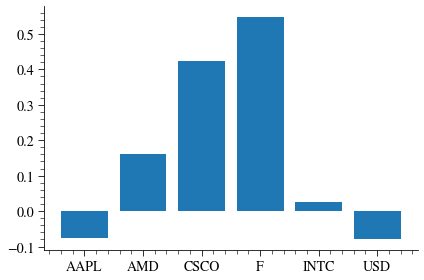

In [12]:
plt.bar(x=TICKERS + ['USD'], height=action)

In [32]:
agent.policy.layers[-1].get_config()#.call()

{'name': 'dense_1',
 'trainable': True,
 'dtype': 'float32',
 'units': 6,
 'activation': 'tanh',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [62]:
layer_input = np.random.normal(loc=5.0, scale=10.0, size=(1,18))
layer_input = tf.convert_to_tensor(layer_input, dtype=tf.float32)
layer_input

<tf.Tensor: shape=(1, 18), dtype=float32, numpy=
array([[  5.9395323 ,  14.430461  , -22.396772  ,  -0.69312054,
          7.6990438 ,   0.33154455,  -9.169061  ,  13.689635  ,
          7.768719  ,  -4.7110457 ,   8.148172  ,  13.2158575 ,
          5.0529265 ,  13.005648  ,   5.782602  ,   1.0477102 ,
         -6.5942054 ,   4.140692  ]], dtype=float32)>

In [63]:
out = agent.policy.layers[-1](layer_input)
out = out / tf.reduce_sum(out)
out

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[-50.35058 ,  50.35058 ,  50.35058 ,  50.335884, -49.335888,
        -50.35058 ]], dtype=float32)>

In [58]:
tf.reduce_sum(out)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>